# Plot QV data

In [ ]:
try:
    import mitiq
except ImportError:
    !pip install mitiq --quiet

In [1]:
import os

import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
from matplotlib.patches import Patch
plt.rcParams.update({"font.family": "serif", "font.size": 14})
import numpy as np

from mitiq import zne

## Load data

In [2]:
directory = os.path.join("data", "quito")

In [3]:
all_raw_counts = np.loadtxt(os.path.join(directory, "all_raw_counts.txt"))
all_scaled_counts = np.loadtxt(os.path.join(directory, "all_scaled_counts.txt"))

test_qubits = [
    list(map(int, qubits.split())) 
    for qubits in open(os.path.join(directory, "qubits.txt")).readlines()
]

ntrials = int(np.loadtxt(os.path.join(directory, "ntrials.txt")))
nshots = int(np.loadtxt(os.path.join(directory, "nshots.txt")))
nshots_zne = int(np.loadtxt(os.path.join(directory, "nshots_zne.txt")))
scale_factors = np.loadtxt(os.path.join(directory, "scale_factors.txt"))

## Set parameters

In [4]:
"""Optionally reduce or downsample scale factors / scaled counts."""
start = 0
stop = len(scale_factors)
step = 1

all_scaled_counts = all_scaled_counts[:, start:stop:step]
scale_factors = scale_factors[start:stop:step]
scale_factors

array([1., 3., 5., 7., 9.])

In [5]:
"""Standard deviation estimation parameters."""
num_resamples = 500  # Parameter for bootstrapped standard deviation
num_batches = 5  # Parameter for empirical standard deviation
z = 2  # Number of standard deviations to show on the plot.

## Helper functions

In [6]:
def get_empirical_std(all_values: np.ndarray, num_batches):
    """Returns the empirical standard deviation of a list of values via batching."""
    # Split all_values into num_batches of equal size
    all_values = np.array(all_values)
    
    # Ensure exact splitting
    batch_size = len(all_values) // num_batches
    all_values = all_values[: batch_size * num_batches]
    
    batches = np.split(all_values, num_batches)
    mean_of_all_batches = np.mean(batches, axis=1)
    return np.std(mean_of_all_batches)


def get_bootstrapped_std(all_values: np.ndarray, num_resamples: int, seed=None):
    """Returns the standard deviation of the bootstrap distribution of the mean, 
    evaluated by resampling with replacement "num_resamples" times the input data.
    """  
    # Resample the "all_values" array "num_resamples" times with replacement
    rng = np.random.RandomState(seed)
    resampled_arrays = [
        rng.choice(all_values, size=len(all_values), replace=True)
        for _ in range(num_resamples)
    ] 
    # Get samples from the bootstrap distribution of the mean
    bootstrap_means = np.mean(resampled_arrays, axis=1)
    return np.std(bootstrap_means)

In [7]:
def plot_figure(results_raw, results_raw_sigma, results_zne, results_zne_sigma, z = 2, title=None):
    plt.figure(figsize=(7, 5))

    test_volumes = sorted(set(len(qubits) for qubits in test_qubits))

    markers = ("o", "v", "s", "p", "X", "D", "<", "*", "8", "x")
    sizes = (50, 50, 50, 100, 100, 100, 100, 100, 100, 100)
    raw_color = "orange"
    zne_color = "blue"

    
    up_bar_raw = results_raw + z * results_raw_sigma
    down_bar_raw = results_raw - z * results_raw_sigma
    up_bar_zne = results_zne + z * results_zne_sigma
    down_bar_zne = results_zne - z * results_zne_sigma

    for i in range(len(results_raw)):
        # Plot mean values
        plt.scatter(len(test_qubits[i]), results_raw[i], marker=markers[i], color=raw_color, ec="black", s=sizes[i], lw=2, alpha=0.75)
        plt.scatter(len(test_qubits[i]), results_zne[i], marker=markers[i], color=zne_color, ec="black", s=sizes[i], lw=2, alpha=0.75)

        # Plot error bars.
        plt.scatter(len(test_qubits[i]), up_bar_raw[i], marker="_", color=raw_color, ec=raw_color, s= 3 * sizes[i], lw=2, alpha=0.75)
        plt.scatter(len(test_qubits[i]), down_bar_raw[i], marker="_", color=raw_color, ec=raw_color, s= 3 * sizes[i], lw=2, alpha=0.75)
        
        plt.scatter(len(test_qubits[i]), up_bar_zne[i], marker="_", color=zne_color, ec=zne_color, s= 3 * sizes[i], lw=2, alpha=0.75)
        plt.scatter(len(test_qubits[i]), down_bar_zne[i], marker="_", color=zne_color, ec=zne_color, s= 3 * sizes[i], lw=2, alpha=0.75)


    # Legend.
    handles = [
        Patch(facecolor=zne_color, edgecolor="black", label="ZNE"),
        Patch(facecolor=raw_color, edgecolor="black", label="Raw")
    ]
    for i, qubits in enumerate(test_qubits):
        handles.append(
                Line2D([0], [0], marker=markers[i], label="-".join(map(str, qubits)), color="black", markerfacecolor="white", markersize=10)
        )
    plt.legend(handles=handles, bbox_to_anchor=(1, 1))

    # Stylize.
    plt.axhline(y=2.0 / 3.0, ls="dashdot", color="black")
    plt.axhline(y=(1.0 + np.log(2)) / 2.0, ls="dashdot", color="black")
    plt.fill_between([min(test_volumes) - 0, max(test_volumes) + 0], y1=(1.0 + np.log(2)) / 2.0, y2=2.0 / 3.0, color="green", alpha=0.25)
    plt.fill_between([min(test_volumes) - 0, max(test_volumes) + 0], y1=min(results_raw), y2=2.0 / 3.0, color="grey", alpha=0.25)

    plt.xticks(sorted(set(len(qubits) for qubits in test_qubits)))
    plt.xlabel("width/depth of circuit $m = d$")
    plt.ylabel("est. heavy output probability $\hat{h}_d$");
    
    if title:
        plt.title(title)
    
    plt.tight_layout()

## Process data

In [8]:
results_raw = []
results_raw_sigma_empirical = []
results_raw_sigma_bootstrap = []

results_zne = []
results_zne_sigma_empirical = []
results_zne_sigma_bootstrap = []

for j, qubits in enumerate(test_qubits):
    print("Processing results of qubits", qubits)
    # Select data from this set of qubits.
    scaled_counts_fixed_qubits = all_scaled_counts[j * ntrials : (j + 1) * ntrials]
    raw_counts = np.array(all_raw_counts[j]) / nshots
    
    zne_trials = []
    for scaled_counts in scaled_counts_fixed_qubits:
        # Get ZNE limit
        noise_scaled_expvalues_single_trial = scaled_counts / nshots_zne
        zne_single_trial = zne.inference.RichardsonFactory.extrapolate(
            scale_factors,
            noise_scaled_expvalues_single_trial,
        )
        zne_trials.append(zne_single_trial)
        
    # Average results over `ntrials` circuits.
    result_raw = np.mean(raw_counts)
    result_zne = np.mean(zne_trials)

    # Get std of results over `ntrials` circuits.
    result_raw_sigma_empirical = get_empirical_std(raw_counts, num_batches=num_batches)
    result_raw_sigma_bootstrap = get_bootstrapped_std(raw_counts, num_resamples=num_resamples)
    
    result_zne_sigma_empirical = get_empirical_std(zne_trials, num_batches=num_batches)
    result_zne_sigma_bootstrap = get_bootstrapped_std(zne_trials, num_resamples=num_resamples)

    # Append data for this qubit set.
    results_raw.append(result_raw)
    results_zne.append(result_zne)
    
    results_raw_sigma_empirical.append(result_raw_sigma_empirical)
    results_raw_sigma_bootstrap.append(result_raw_sigma_bootstrap)
    
    results_zne_sigma_empirical.append(result_zne_sigma_empirical)
    results_zne_sigma_bootstrap.append(result_zne_sigma_bootstrap)


# Convert to numpy.
results_raw = np.array(results_raw)
results_zne = np.array(results_zne)

results_raw_sigma_empirical = np.array(results_raw_sigma_empirical)
results_raw_sigma_bootstrap = np.array(results_raw_sigma_bootstrap)

results_zne_sigma_empirical = np.array(results_zne_sigma_empirical)
results_zne_sigma_bootstrap = np.array(results_zne_sigma_bootstrap)

Processing results of qubits [0, 1, 2]
Processing results of qubits [0, 1, 3]
Processing results of qubits [1, 3, 4]
Processing results of qubits [0, 1, 2, 3]
Processing results of qubits [0, 1, 3, 4]
Processing results of qubits [0, 1, 2, 3, 4]


## Plot results

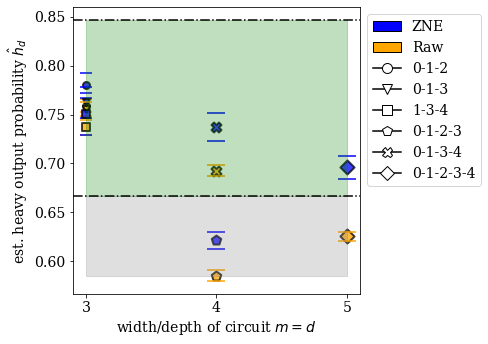

In [9]:
plot_figure(results_raw, results_raw_sigma_bootstrap, results_zne, results_zne_sigma_bootstrap, z=z)

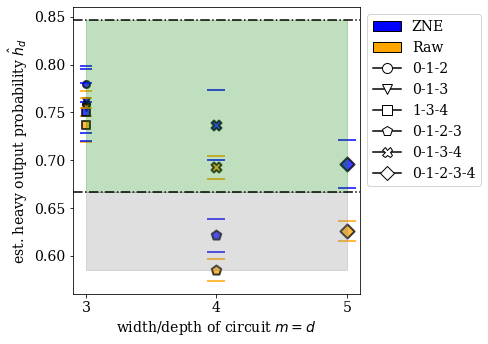

In [10]:
plot_figure(results_raw, results_raw_sigma_empirical, results_zne, results_zne_sigma_empirical, z=z)